In [1]:

from contextlib import contextmanager
from datetime import datetime, timedelta
import sqlite3
import os


@contextmanager
def db(db_filename='stock.db'):
    
    conn = sqlite3.connect(os.path.join('..', 'data', db_filename), detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)

    cur = conn.cursor()
    
    yield conn, cur
    
    conn.close()


In [2]:
from zipline.api import order, order_target, record, symbol
from zipline.finance import commission, slippage
import zipline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

def predict(date, stock): # ~Perfect~ Predictor
    
    with db() as (conn, cur):
        
        cur.execute("SELECT date, adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC LIMIT 1", 
                    [stock, (date + timedelta(days=-5)).strftime('%Y-%m-%d'), (date + timedelta(days=0)).strftime('%Y-%m-%d')])
        before = cur.fetchall()[0]
        
        cur.execute("SELECT date, adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1", 
                    [stock, (date + timedelta(days=1)).strftime('%Y-%m-%d'), (date + timedelta(days=5)).strftime('%Y-%m-%d')])
        after = cur.fetchall()[0]
        
        if after[1] > before[1]:
            return True
        else:
            return False


In [10]:
stock = 'INTC'

def initialize(context):
    context.set_commission(commission.PerShare(cost=0, min_trade_cost=1.0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):
    
    date = data.current(symbol(stock), 'last_traded').to_datetime()
    
    pred = predict(date + timedelta(days=0), stock)
    
    shares = context.portfolio.positions[symbol(stock)].amount
    
    # print(data.current(symbol('AAPL'), 'last_traded').to_datetime())
    # print(context.portfolio.positions[symbol('AAPL')].amount)
    print(date, data.current(symbol(stock), 'price'), pred, shares, round(context.portfolio.cash))
    
    if pred:
        if context.portfolio.cash > data.current(symbol(stock), 'price'):
            order(symbol(stock), context.portfolio.cash // data.current(symbol(stock), 'price'))
    else:
        if shares > 0:
            order_target(symbol(stock), 0)
        
    record(AAPL=data.current(symbol(stock), 'price'))
    record(shares=context.portfolio.positions[symbol(stock)].amount)

start = pd.to_datetime('2017-01-01').tz_localize('US/Eastern')
end = pd.to_datetime('2018-03-01').tz_localize('US/Eastern')
perf = zipline.run_algorithm(start, end, initialize, 1000, handle_data=handle_data)

2017-01-03 00:00:00+00:00 36.6 False 0 1000
2017-01-04 00:00:00+00:00 36.410000000000004 False 0 1000
2017-01-05 00:00:00+00:00 36.35 True 0 1000
2017-01-06 00:00:00+00:00 36.480000000000004 True 27 14
2017-01-09 00:00:00+00:00 36.61 False 27 14
2017-01-10 00:00:00+00:00 36.54 True 0 1000
2017-01-11 00:00:00+00:00 36.95 False 27 1
2017-01-12 00:00:00+00:00 36.71 True 0 991
2017-01-13 00:00:00+00:00 36.79 True 26 34
2017-01-17 00:00:00+00:00 36.800000000000004 False 26 34
2017-01-18 00:00:00+00:00 36.76 False 0 988
2017-01-19 00:00:00+00:00 36.57 True 0 988
2017-01-20 00:00:00+00:00 36.94 False 27 -10
2017-01-23 00:00:00+00:00 36.77 True 0 982
2017-01-24 00:00:00+00:00 37.62 True 26 3
2017-01-25 00:00:00+00:00 37.800000000000004 False 26 3
2017-01-26 00:00:00+00:00 37.56 True 0 978
2017-01-27 00:00:00+00:00 37.980000000000004 False 26 -10
2017-01-30 00:00:00+00:00 37.42 False 0 962
2017-01-31 00:00:00+00:00 36.82 False 0 962
2017-02-01 00:00:00+00:00 36.52 True 0 962
2017-02-02 00:00:00

2017-10-25 00:00:00+00:00 40.78 True 0 924
2017-10-26 00:00:00+00:00 41.35 True 22 14
2017-10-27 00:00:00+00:00 44.4 False 22 14
2017-10-30 00:00:00+00:00 44.37 True 0 989
2017-10-31 00:00:00+00:00 45.49 True 22 -13
2017-11-01 00:00:00+00:00 46.71 True 22 -13
2017-11-02 00:00:00+00:00 47.1 False 22 -13
2017-11-03 00:00:00+00:00 46.34 True 0 1005
2017-11-06 00:00:00+00:00 46.7 True 21 24
2017-11-07 00:00:00+00:00 46.78 False 21 24
2017-11-07 00:00:00+00:00 46.78 False 21 24
2017-11-09 00:00:00+00:00 46.300000000000004 False -21 1966
2017-11-10 00:00:00+00:00 45.58 True -21 1966
2017-11-13 00:00:00+00:00 45.75 True 22 -2
2017-11-14 00:00:00+00:00 45.86 False 22 -2
2017-11-15 00:00:00+00:00 45.46 True 0 997
2017-11-16 00:00:00+00:00 45.65 False 21 38
2017-11-17 00:00:00+00:00 44.63 False 0 974
2017-11-20 00:00:00+00:00 44.62 True 0 974
2017-11-21 00:00:00+00:00 44.94 False 21 29
2017-11-22 00:00:00+00:00 44.65 True 0 966
2017-11-24 00:00:00+00:00 44.75 False 21 25
2017-11-27 00:00:00+00:0

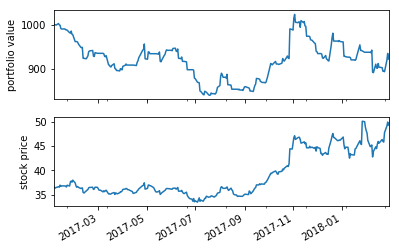

In [5]:
ax1 = plt.subplot(211)
perf.portfolio_value.plot()
ax1.set_ylabel('portfolio value')
ax2 = plt.subplot(212, sharex=ax1)
perf.AAPL.plot(ax=ax2)
ax2.set_ylabel('stock price')
plt.show()

In [6]:
print(perf.columns)
perf[['period_open', 'period_close', 'starting_cash', 'ending_cash', 'portfolio_value']].head()

Index(['AAPL', 'algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'shares', 'sharpe', 'short_exposure',
       'short_value', 'shorts_count', 'sortino', 'starting_cash',
       'starting_exposure', 'starting_value', 'trading_days', 'transactions',
       'treasury_period_return'],
      dtype='object')


,period_open,period_close,starting_cash,ending_cash,portfolio_value
2017-01-03 21:00:00+00:00,2017-01-03 14:31:00+00:00,2017-01-03 21:00:00+00:00,1000.00,1000.00,1000.00
2017-01-04 21:00:00+00:00,2017-01-04 14:31:00+00:00,2017-01-04 21:00:00+00:00,1000.00,1000.00,1000.00
2017-01-05 21:00:00+00:00,2017-01-05 14:31:00+00:00,2017-01-05 21:00:00+00:00,1000.00,1000.00,1000.00
2017-01-06 21:00:00+00:00,2017-01-06 14:31:00+00:00,2017-01-06 21:00:00+00:00,1000.00,14.04,999.00
2017-01-09 21:00:00+00:00,2017-01-09 14:31:00+00:00,2017-01-09 21:00:00+00:00,14.04,14.04,1002.51
